In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import contextily
basemap = contextily.providers.Stamen.TonerLite

import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Repositories\gnn-traffic\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plots

In [ ]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader('data')
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

In [133]:
graph = nx.Graph()
for edge, weight in zip(dataset.edge_index.T, dataset.edge_weight):
    graph.add_edge(*edge, weight=weight)
graph.remove_edges_from(nx.selfloop_edges(graph))

In [134]:
locations = pd.read_csv('https://raw.githubusercontent.com/tijsmaas/TrafficPrediction/master/data/metr-la/graph_sensor_locations.csv')
locations = locations[['longitude', 'latitude']].to_numpy()

In [135]:
speed = np.load('data/node_values.npy')
speed = speed[:,:,0] # timestamp, sensor, feature[speed, timeofday]

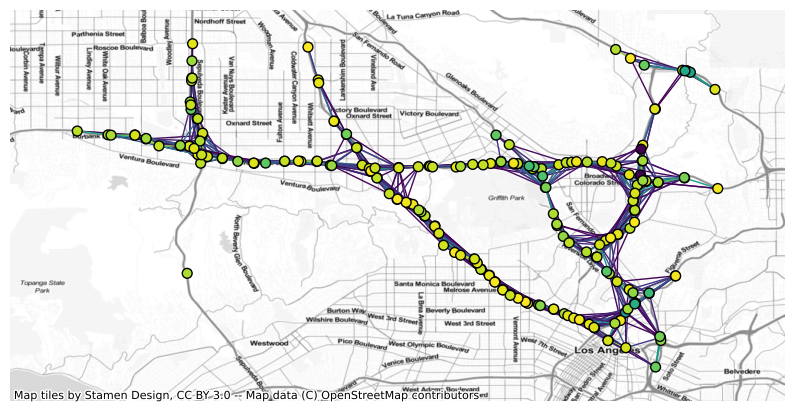

In [144]:
positions = dict(zip(graph.nodes, locations[graph.nodes]))
node_colors = speed[0,:][graph.nodes]
edge_colors = [graph[x][y]['weight'] for x,y in graph.edges]

fig, ax = plt.subplots(figsize=(10,10))
nx.draw(graph, positions, node_color=node_colors, edge_color=edge_colors, edgecolors='black', ax=ax, node_size=50)
contextily.add_basemap(ax=ax, crs=4326, source=basemap)

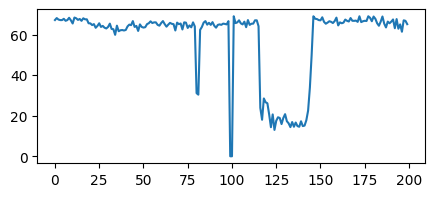

In [79]:
plt.figure(figsize=(5,2))
plt.plot(speed[-200:,0])

In [145]:
adjacency = np.load('data/adj_mat.npy')

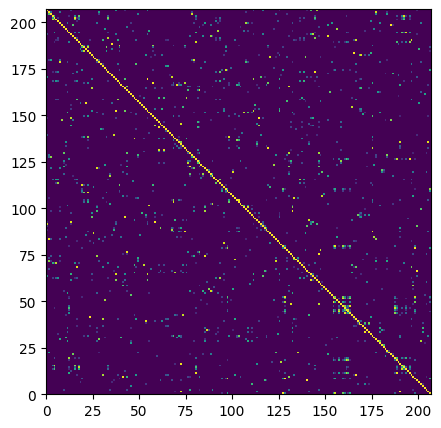

In [148]:
fig, ax = plt.subplots(figsize=(5,5))
ax.pcolormesh(adjacency[::-1,:])
ax.set_aspect('equal')

# Whats next

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from src import METRLADataModule, TemporalGNN
from src.printer import PrintMetricsCallback

In [6]:
import warnings
warnings.filterwarnings('ignore', '.*does not have many workers.*')

In [14]:
data = METRLADataModule(raw_data_dir='data', train_steps=12, predict_steps=12, num_workers=0, batch_size=8)
model = TemporalGNN(in_features=2, hidden_features=64)

In [15]:
next(iter(data.val_dataloader()))

DataBatch(x=[1656, 2, 12], edge_index=[2, 13776], edge_attr=[13776], y=[1656, 12], batch=[1656], ptr=[9])

In [16]:
best_checkpointer = ModelCheckpoint(
    save_top_k=1, save_last=True, monitor='val_loss', mode='max', filename='best')
csv_logger = CSVLogger('')
printer = PrintMetricsCallback(
    metrics=['val_loss', 'train_loss'])

trainer = pl.Trainer(
    log_every_n_steps=1,
    logger=csv_logger,
    callbacks=[best_checkpointer, printer],
    max_epochs=10,
    accelerator='auto',
    devices=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model, data)


  | Name      | Type    | Params
--------------------------------------
0 | tgnn      | A3TGCN  | 25.4 K
1 | linear    | Linear  | 780   
2 | act       | ReLU    | 0     
3 | criterion | MSELoss | 0     
--------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.105     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s]

c:\Repositories\gnn-traffic\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1656. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]epoch: -1
train_loss: 0.2684083580970764
────────────────────────────────────────────────────────────────────────────────
Epoch 0:  12%|█▏        | 600/5138 [05:47<43:47,  1.73it/s, loss=0.415, v_num=9]